# Object Detection with PyTorch

The pretrained Faster-RCNN ResNet-50 model we are going to use expects the input image tensor to be in the form ```[n, c, h, w]``` 
where 
- n is the number of images
- c is the number of channels , for RGB images its 3
- h is the height of the image
- w is the widht of the image

The model will return
- Bounding boxes [x0, y0, x1, y1]  all all predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.
- Labels of all predicted classes.
- Scores of each predicted label.



In [1]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [2]:
def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class
  


def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

--2020-12-11 13:19:49--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 104.198.7.33
Connecting to www.wsha.org (www.wsha.org)|104.198.7.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>]   1.83M   643KB/s    in 2.9s    

2020-12-11 13:19:53 (643 KB/s) - ‘people.jpg’ saved [1923610/1923610]



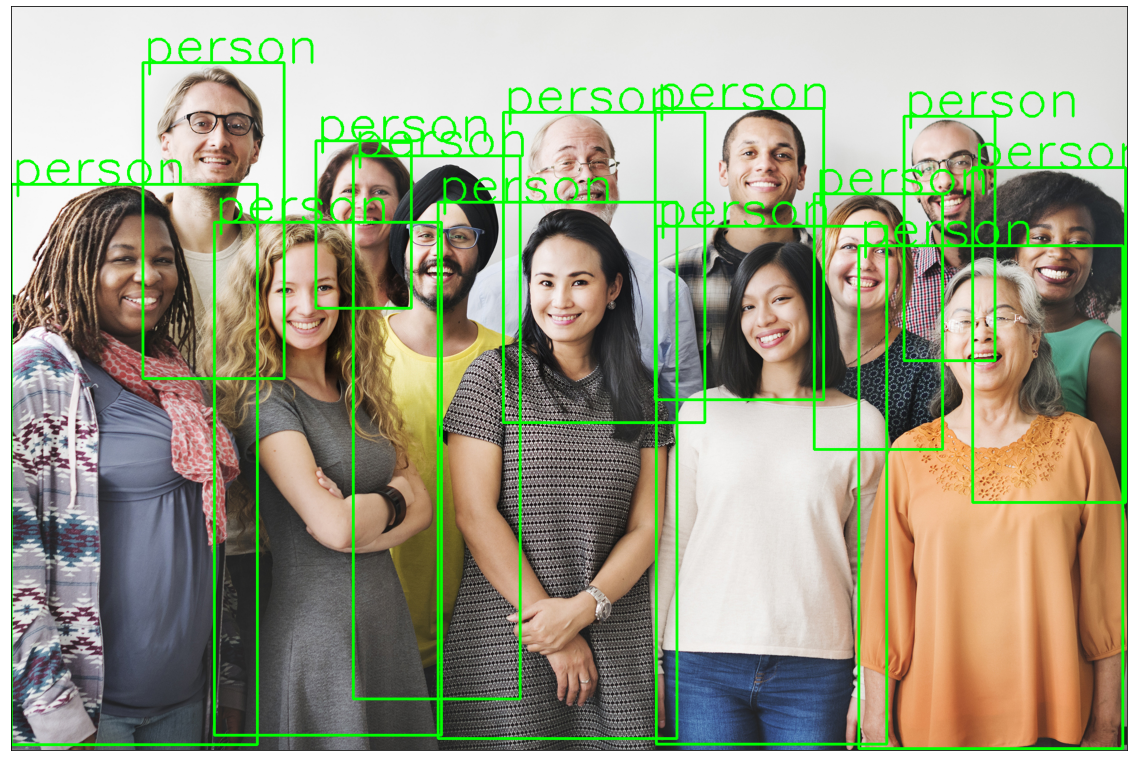

In [ ]:
# download an image for inference
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O people.jpg

# use the api pipeline for object detection
# the threshold is set manually, the model sometimes predicts
# random structures as a potential object, so we set a threshold to keep objects 
# with better prediction scores.
object_detection_api('./people.jpg', threshold=0.8)

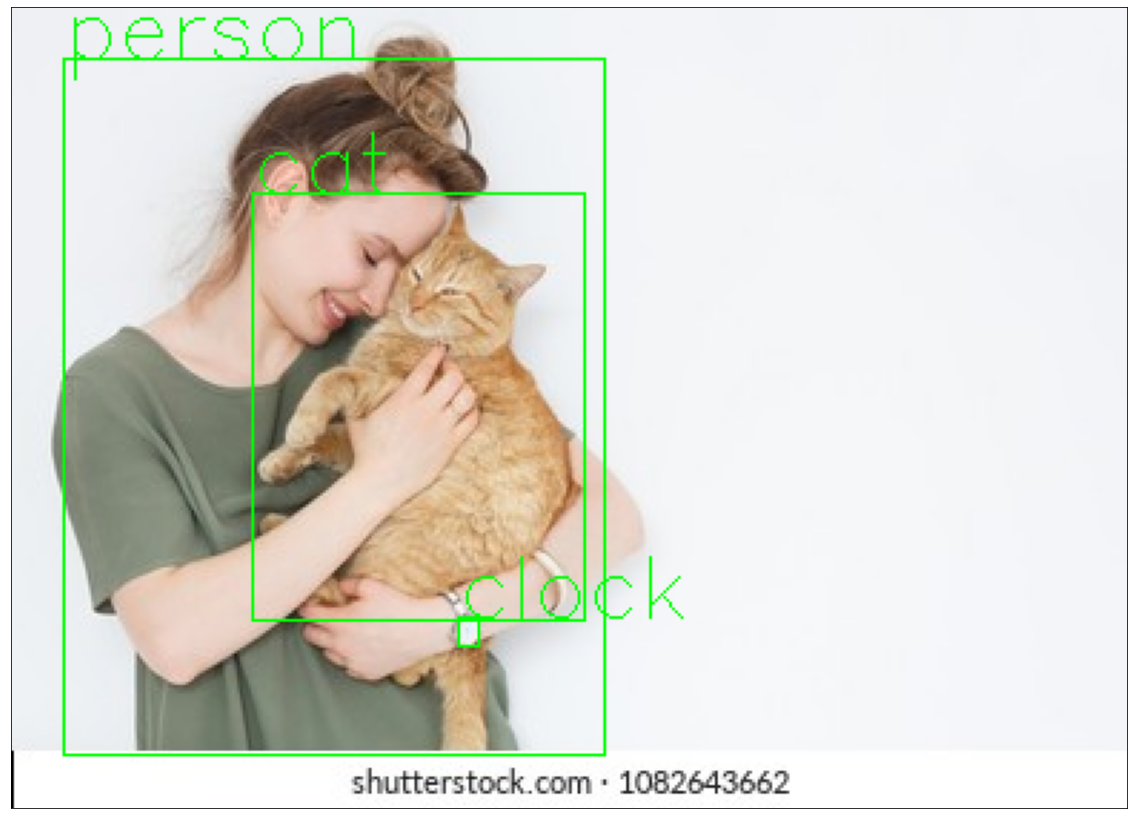

In [4]:
object_detection_api('./cat-human.jpg', rect_th=1, text_th=1, text_size=1)

--2020-12-11 13:19:56--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.152.155
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.152.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178423 (2.1M) [image/jpeg]
Saving to: ‘cars.jpg’

cars.jpg            100%[===================>]   2.08M  6.95MB/s    in 0.3s    

2020-12-11 13:19:57 (6.95 MB/s) - ‘cars.jpg’ saved [2178423/2178423]



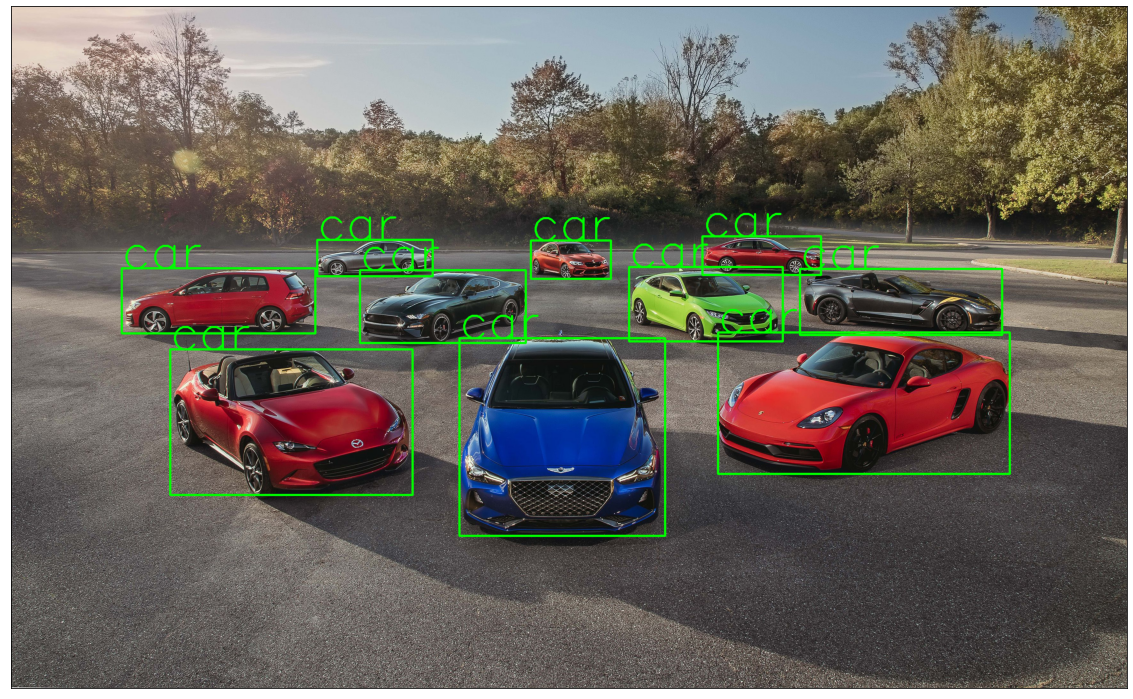

In [ ]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O cars.jpg
  
object_detection_api('./cars.jpg', rect_th=6, text_th=5, text_size=5)

--2020-12-11 13:20:00--  https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191490 (187K) [image/jpeg]
Saving to: ‘traffic_scene.jpg’

traffic_scene.jpg   100%[===================>] 187.00K  --.-KB/s    in 0.03s   

2020-12-11 13:20:00 (5.65 MB/s) - ‘traffic_scene.jpg’ saved [191490/191490]



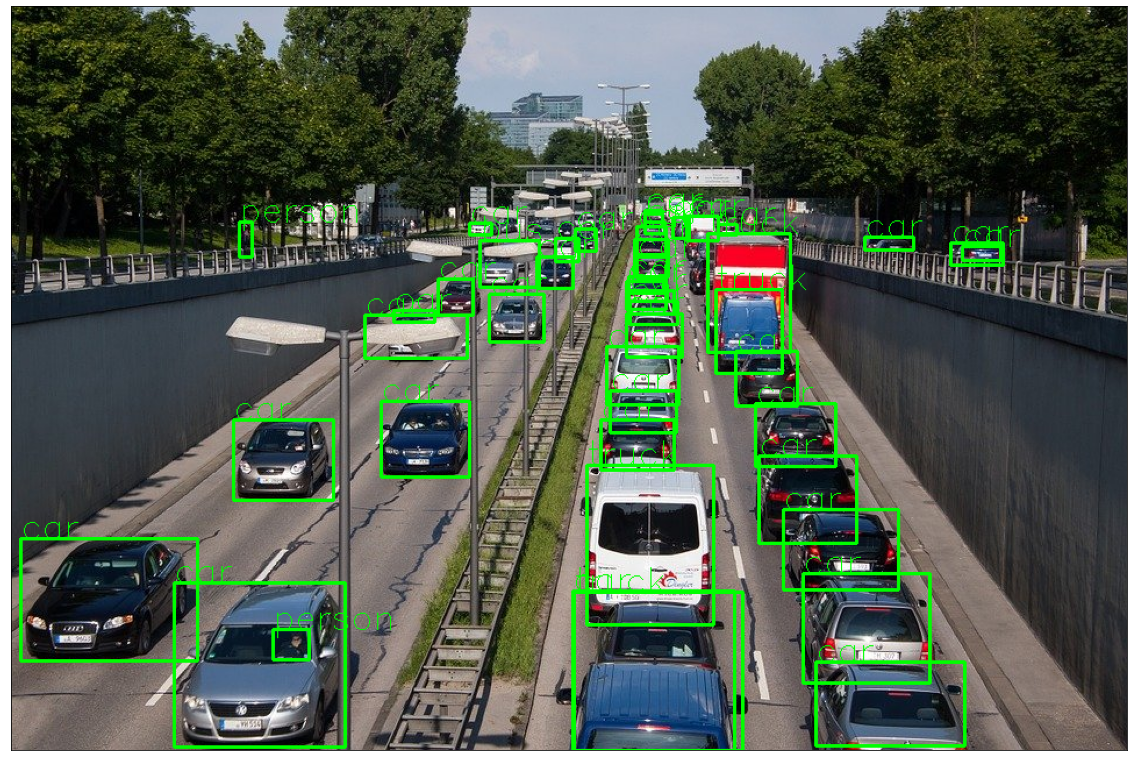

In [ ]:
!wget https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg -O traffic_scene.jpg
  
object_detection_api('./traffic_scene.jpg', rect_th=2, text_th=1, text_size=1)

--2020-12-11 13:20:03--  https://images.unsplash.com/photo-1458169495136-854e4c39548a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.154.208, 2a04:4e42:24::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.154.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168686 (1.1M) [image/jpeg]
Saving to: ‘traffic_scene2.jpg’

traffic_scene2.jpg  100%[===================>]   1.11M  1.80MB/s    in 0.6s    

2020-12-11 13:20:04 (1.80 MB/s) - ‘traffic_scene2.jpg’ saved [1168686/1168686]



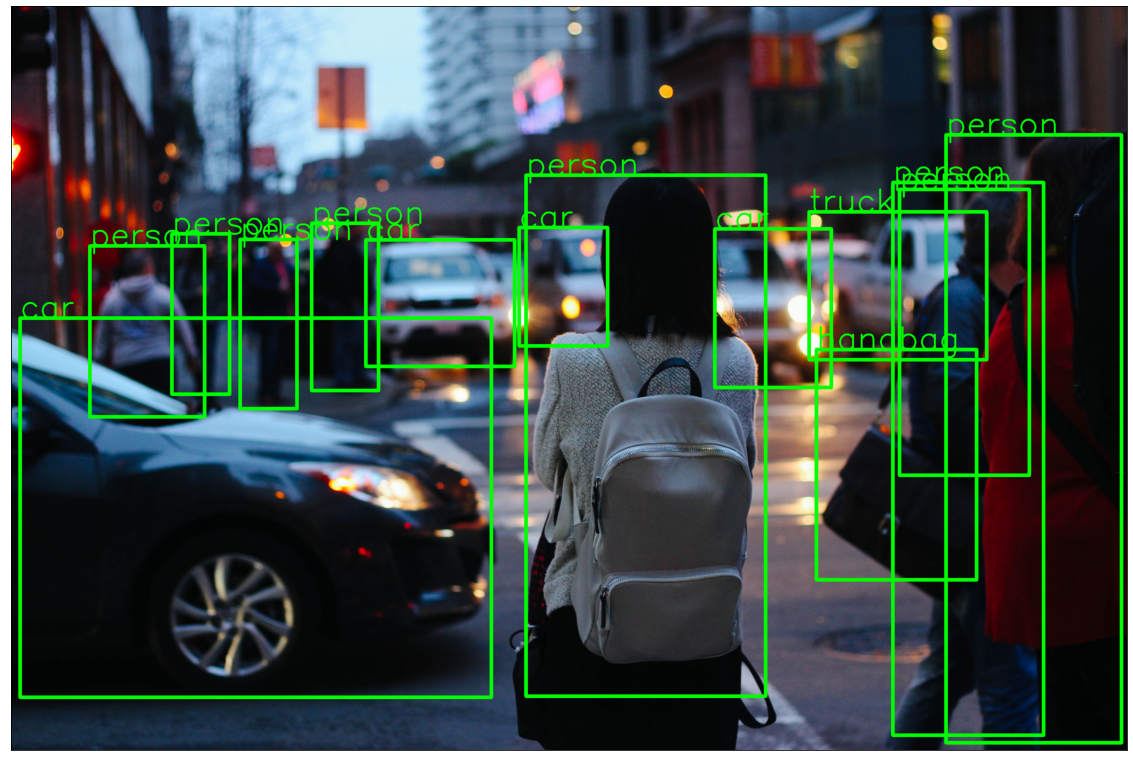

In [ ]:
!wget https://images.unsplash.com/photo-1458169495136-854e4c39548a -O traffic_scene2.jpg
  
object_detection_api('./traffic_scene2.jpg', rect_th=15, text_th=7, text_size=5, threshold=0.8)  

# Comparing the inference time of model in CPU & GPU



In [6]:
import time

def check_inference_time(image_path, gpu=False):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  model.eval()
  img = Image.open(image_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if gpu:
    model.cuda()
    img = img.cuda()
  else:
    model.cpu()
    img = img.cpu()
  start_time = time.time()
  pred = model([img])
  end_time = time.time()
  return end_time-start_time

## Inference time for Object Detection

In [7]:
img_paths = [path for path in os.listdir(".") if path.split(".")[-1].lower() in ["jpeg", "jpg", "png"] ]

gpu_time = sum([check_inference_time(img_path, gpu=True) for img_path in img_paths])/len(img_paths)
cpu_time = sum([check_inference_time(img_path, gpu=False) for img_path in img_paths])/len(img_paths)


print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))



Average Time take by the model with GPU = 0.32950878143310547s
Average Time take by the model with CPU = 4.6369569301605225s
